In [ ]:
# Importing the libraries

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from io import BytesIO
import pycountry
import plotly.express as px
from scipy.stats import normaltest
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import praw
from textblob import TextBlob
from statsmodels.formula.api import ols
from scipy.stats import kruskal
from scipy.stats import wilcoxon
from dotenv import load_dotenv
from os import getenv
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash
from geopy.geocoders import Nominatim
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller
from numpy import log
import itertools
from itertools import product
import warnings

Create the Dataset

In [ ]:
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/EI_ISBU_Q?format=TSV&compressed=true' # The url of the data
headers = {'Accept-Encoding': 'gzip'} # This is important to get the gzip file
response = requests.get(url, headers=headers) # Get the data from the url

buf = BytesIO(response.content) # Read the gzip file
f = gzip.GzipFile(fileobj=buf) # Unzip the gzip file
content = f.read() # Read the unzipped file

df = pd.read_csv(BytesIO(content), sep='\t') # Read the unzipped file as a dataframe
print(df.head())


In [ ]:
# Melt the dataframe so all the Quarters are in one column
df = pd.melt(df, id_vars=['freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD'], var_name='Quarter', value_name='Value')

# The column freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD is split into 6 columns
df[['freq','unit','s_adj','indic','nace_r2','geo\TIME_PERIOD']] = df['freq,unit,s_adj,indic,nace_r2,geo\\TIME_PERIOD'].str.split(',', expand=True)

# svr the column freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD and move Quarter and Value to the back
df = df.drop(['freq,unit,s_adj,indic,nace_r2,geo\\TIME_PERIOD'], axis=1)
df = df[['freq', 'unit', 's_adj', 'indic', 'nace_r2','geo\TIME_PERIOD','Quarter', 'Value']]

# Print the first 5 rows of the dataframe
df.head()

In [ ]:
df.info()

In [ ]:
# set values containing ":" to NaN
df.loc[df['Value'].str.contains(':'), 'Value'] = pd.np.nan

In [ ]:
# if the Value column has an alphabetical character remove it
df['Value'] = df['Value'].str.replace('[a-zA-Z]', '')

In [ ]:
#Convert the Value column to a float
df['Value'] = df['Value'].astype(float)

In [ ]:
df.head()

In [ ]:
countrycode_map = {c.alpha_2: c.alpha_3 for c in pycountry.countries} # Create a dictionary of country codes

#Uk is not a country code so we will change it to GB
df.loc[df['geo\\TIME_PERIOD'] == 'UK', 'geo\\TIME_PERIOD'] = 'GB'

df['Country_Codes'] = df['geo\\TIME_PERIOD'].map(countrycode_map) # Map the country codes to the dataframe


In [ ]:
# Print unique values of the Country_Codes column
print(df['Country_Codes'].unique())

In [ ]:
# Perform Normailty tests for the Value column grouped by geo\TIME_PERIOD, indic, and s_adj

df.set_index(['geo\\TIME_PERIOD', 'indic', 's_adj'], inplace=True)

# Perform normality test on the Value column grouped by geo\TIME_PERIOD, indic, and s_adj
grouped = df.groupby(['geo\\TIME_PERIOD', 'indic', 's_adj'])['Value']
pvalues = grouped.apply(lambda x: normaltest(x.dropna())[1])

# Add p-values to a new column in the original DataFrame
df.loc[pvalues.index, 'pvalue'] = pvalues

#Add a new column to the dfi dataframe called 'normal' and set it to True if the pvalue is greater than 0.05 and False if it is less than 0.05
df['normal'] = df['pvalue'] > 0.05

# Move the index back to columns
df.reset_index(inplace=True)

Explore the Data

In [ ]:
# Create a country plot with the Value column as the color and the Quarter column as the animation, show for indicators '[IS-IP]' and Seasonal Adjustment 'NSA'

fig = px.choropleth(df[(df['indic'] == 'IS-IP') & (df['s_adj'] == 'NSA')], locations="Country_Codes",color="Value", hover_name="geo\TIME_PERIOD", animation_frame="Quarter", color_continuous_scale=px.colors.sequential.Plasma, range_color=(0, 100), scope='europe') # Create the plot

fig.show()

In [ ]:
df.head()

In [ ]:
df.describe(include='all')

In [ ]:
# Group the dataframe by geo\TIME_PERIOD, indic, and s_adj and show descriptive statistics
df.groupby(['s_adj', 'indic', 'geo\\TIME_PERIOD']).describe(include='all')

In [ ]:
# Seperate the geo\TIME_PERIOD value that equals 'IE' into a seperate dataframe
IE = df[df['geo\TIME_PERIOD'] == 'IE']

In [ ]:
#Perform EDA on the IE dataframe
IE.info()

In [ ]:
IE.describe(include='all')

In [ ]:
# Perform Statistical Analysis on the IE dataframe
IE.describe(include='all')

IE.groupby(['indic','s_adj']).describe()

In [ ]:
# Create histomgrams of the Value column for the IE dataframe grouped by 'indic' and 's_adj', faceted by the 'normal' column
sns.FacetGrid(IE, col='indic', row='s_adj', hue='normal').map(sns.histplot, 'Value').add_legend()

In [ ]:
# Create histograms of the Value column for the IE dataframe grouped by 'indic' and 's_adj', where the 'normal' column is True
sns.FacetGrid(IE[IE['normal'] == True], row='indic', col='s_adj', hue= 's_adj').map(sns.histplot, 'Value').add_legend()

In [ ]:
# Visualise the IE dataframe showing statistical analysis using seaborn  and matplotlib  libraries splitting the data by insdicators and seasonanal adjustment
sns.catplot(x="indic", y="Value", hue="s_adj", kind="box", data=IE);

Perform Statistical Tests

Perform a T-test

In [ ]:
# Compare the Number of persons employed index, non-seasonally adjusted, for Ireland and EU28 using a t-test
from scipy.stats import ttest_ind

# Filter the DataFrame to only include rows with geo\TIME_PERIOD values of 'EU28' and 'IE',
# 'IS-EPI' for indic, and 'NSA' for s_adj
df_t = df[(df['geo\\TIME_PERIOD'].isin(['EU28', 'IE'])) & (df['indic'] == 'IS-EPI') & (df['s_adj'] == 'NSA')]

# Use interpolation to fill in missing values
df_t['Value'] = df_t['Value'].interpolate(both_directions=True)

# Drop the first 2 rows of the DataFrame
df_t = df_t.iloc[2:]

# Split the DataFrame into two separate DataFrames, one for each geo\TIME_PERIOD value
df_eu28 = df_t[df_t['geo\\TIME_PERIOD'] == 'EU28']
df_ie = df_t[df_t['geo\\TIME_PERIOD'] == 'IE']

In [64]:
from scipy.stats import levene

# Test samples df_eu28 and df_ie for equal variances
statistic, p_value = levene(df_eu28['Value'], df_ie['Value'])
alpha = 0.05  # significance level

if p_value < alpha:
    print("Reject null hypothesis: Samples have different variances.")
else:
    print("Fail to reject null hypothesis: Samples have equal variances.")


Reject null hypothesis: Samples have different variances.


In [65]:
# Perform the t-test - note that we set equal_var=False as we have already tested for equal variances
t_stat, p_val = ttest_ind(df_eu28['Value'], df_ie['Value'], equal_var=False)

print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.4f}")


t-statistic: -2.3341
p-value: 0.0203


Perform a One-Way ANOVA

In [139]:
# Filter the dataframe to only include rows where the normal column equals True and the indic column equals 'IS-EPI' and the s_adj column equals 'NSA'
df_Anova = df[(df['normal'] == True) & (df['indic'] == 'IS-EPI') & (df['s_adj'] == 'NSA')]

# Fill in missing values using interpolation
df_Anova['Value'] = df_Anova['Value'].interpolate(both_directions=True)

# Remove first 9 rows of the dataframe
df_Anova = df_Anova.iloc[9:]

C:\Users\Paul\AppData\Local\Temp\ipykernel_3860\213264315.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [140]:
# Create a list of the unique geo\TIME_PERIOD values
geo_time_periods = df_Anova['geo\\TIME_PERIOD'].unique()

#Make sure the groups have the same sample size
min_sample_size = df_Anova['geo\\TIME_PERIOD'].value_counts().min()
df_Anova = df_Anova.groupby('geo\\TIME_PERIOD').apply(lambda x: x.sample(min_sample_size))

In [142]:
#Perform the ANOVA
f_stat, p_val = f_oneway(*[df_Anova[df_Anova['geo\\TIME_PERIOD'] == geo_time_period]['Value'] for geo_time_period in geo_time_periods])

# Show the F-statistic and p-value
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4f}")

# Show the degrees of freedom for the ANOVA test
print(f"Degrees of freedom: {len(geo_time_periods) - 1}")

#Print th resuts of the ANOVA test
if p_val < 0.05:
    print("Reject null hypothesis - Significant differences exist between groups.")
else:
    print("Accept null hypothesis - No significant difference between groups.")

F-statistic: 4.7762
p-value: 0.0000
Degrees of freedom: 8
Reject null hypothesis - Significant differences exist between groups.


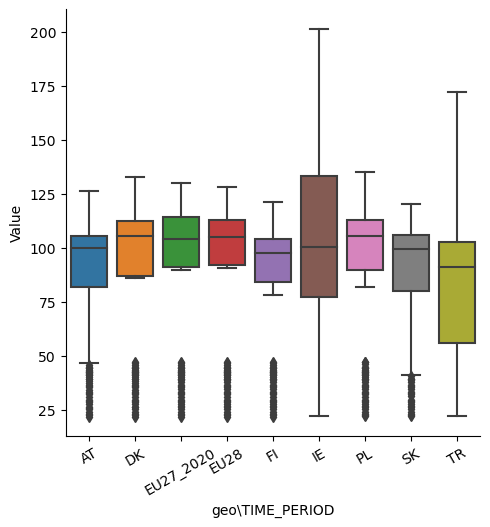

In [126]:
#Show the diferences between the groups using a boxplot with slanted x-axis labels
sns.catplot(x="geo\\TIME_PERIOD", y="Value", kind="box", data=df_Anova).set_xticklabels(rotation=30)

In [127]:
# Perform a Tukey's Range Test to determine which groups are significantly different from each other
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's Range Test
tukey_results = pairwise_tukeyhsd(df_Anova['Value'], df_Anova['geo\\TIME_PERIOD'], 0.05)

# Print the results
print(tukey_results)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower    upper  reject
-----------------------------------------------------------
       AT        DK   5.5708 0.8247  -5.4994 16.6411  False
       AT EU27_2020   6.1448 0.7316  -4.9255  17.215  False
       AT      EU28   5.8785 0.7771  -5.1917 16.9488  False
       AT        FI  -0.5205    1.0 -11.5908 10.5497  False
       AT        IE  15.8997 0.0003   4.8295   26.97   True
       AT        PL   6.4238 0.6807  -4.6465 17.4941  False
       AT        SK  -0.2008    1.0  -11.271 10.8695  False
       AT        TR  -1.5506    1.0 -12.6209  9.5196  False
       DK EU27_2020   0.5739    1.0 -10.4964 11.6442  False
       DK      EU28   0.3077    1.0 -10.7626 11.3779  False
       DK        FI  -6.0914  0.741 -17.1617  4.9789  False
       DK        IE  10.3289 0.0899  -0.7414 21.3992  False
       DK        PL   0.8529    1.0 -10.2173 11.9232  False
       DK        SK  -5.7716 0.7943 -16.

Perform a Two-Way ANOVA

In [156]:
# Create a dataframe called prep1 where the indic column equals 'IS-EPI' and the s_adj column contains 'SCA and 'NSA' values and the normal column equals True
twa = df[(df['indic'] == 'IS-EPI') & (df['normal'] == True)]

In [157]:
#Change the name of the geo\TIME_PERIOD column to geo in the df dataframe
twa.rename(columns={'geo\\TIME_PERIOD': 'geo'}, inplace=True)

C:\Users\Paul\AppData\Local\Temp\ipykernel_3860\4015434628.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [158]:
# Drop the AT, EL, FI values from the geo column as they don't have NSA and SCA values
twa = twa[~twa['geo'].isin(['AT', 'EL', 'FI'])]

In [159]:
# Drop first 7 rows of the dataframe
twa = twa.iloc[7:]

In [160]:
#Make sure the groups have the same sample size
min_sample_size = twa['geo'].value_counts().min()
twa = twa.groupby('geo').apply(lambda x: x.sample(min_sample_size))

<Axes: xlabel='geo', ylabel='Value'>

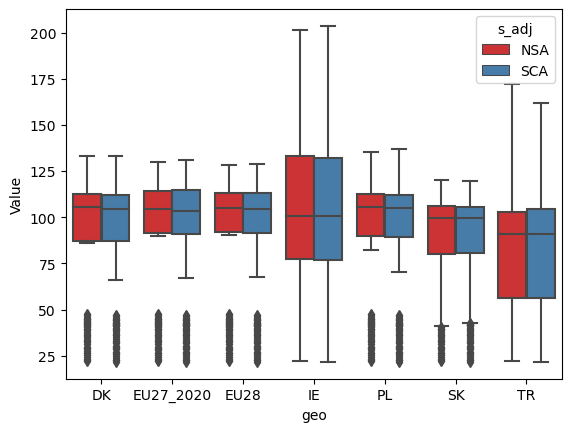

In [163]:
# generate a boxplot to see the data distribution by geo and s_adj
sns.boxplot(x="geo", y="Value", hue="s_adj", data=twa, palette="Set1") 

In [161]:
# Perform two-way ANOVA
# The effect of seasonality, the effect of country, and the interaction between seasonality and country
model = ols('Value ~ s_adj + geo + s_adj:geo', data = twa).fit()
aov2 = sm.stats.anova_lm(model, type=2)
print(aov2)

               df        sum_sq       mean_sq         F        PR(>F)
s_adj         1.0  3.634479e+01     36.344792  0.031010  8.602320e-01
geo           6.0  6.554134e+04  10923.556141  9.320296  3.982605e-10
s_adj:geo     6.0  1.457720e+01      2.429534  0.002073  1.000000e+00
Residual   2401.0  2.814015e+06   1172.018096       NaN           NaN


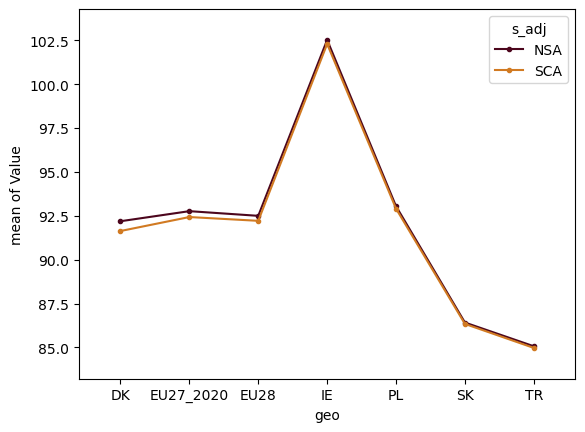

In [173]:
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
fig = interaction_plot(x=twa['geo'], trace=twa['s_adj'], response=twa['Value'], 
    colors=['#4c061d','#d17a22'])
plt.show()

In [177]:
# Perform a Tukey's Range Test to determine which groups are significantly different from each other
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's Range Test
tukey_results = pairwise_tukeyhsd(twa['Value'], twa['geo'], 0.05)

# Print the results
print(tukey_results)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower    upper  reject
-----------------------------------------------------------
       DK EU27_2020   0.6854    1.0  -6.9951  8.3659  False
       DK      EU28   0.4446    1.0  -7.2358  8.1251  False
       DK        IE  10.4937 0.0011   2.8133 18.1742   True
       DK        PL   1.0634 0.9996  -6.6171  8.7438  False
       DK        SK  -5.5315  0.338  -13.212   2.149  False
       DK        TR  -6.8899 0.1126 -14.5704  0.7905  False
EU27_2020      EU28  -0.2408    1.0  -7.9212  7.4397  False
EU27_2020        IE   9.8083 0.0032   2.1278 17.4888   True
EU27_2020        PL    0.378    1.0  -7.3025  8.0584  False
EU27_2020        SK  -6.2169 0.2037 -13.8974  1.4636  False
EU27_2020        TR  -7.5754 0.0561 -15.2558  0.1051  False
     EU28        IE  10.0491 0.0022   2.3686 17.7295   True
     EU28        PL   0.6187    1.0  -7.0617  8.2992  False
     EU28        SK  -5.9761 0.2462 -13.

In [178]:
# Perform a Tukey's Range Test to determine which groups are significantly different from each other
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's Range Test
tukey_results = pairwise_tukeyhsd(twa['Value'], twa['s_adj'], 0.05)

# Print the results
print(tukey_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   NSA    SCA  -0.2454 0.8615 -3.0023 2.5116  False
---------------------------------------------------


Perform a Wilcoxon Signed-Rank Test

In [ ]:
# Find countries that have false values for the normal column where the indic column equals 'IS-HWI'
df[(df['normal'] == False) & (df['indic'] == 'IS-HWI')]['geo\\TIME_PERIOD'].unique()

In [ ]:
# Filter the data
df_HWI = df[(df['indic'] == 'IS-HWI')]

# Filter out NaN values from the 'Value' column
df_HWI = df_HWI.dropna(subset=['Value'])


In [ ]:

# Select the two groups to compare
group1 = df_HWI[df_HWI['geo\\TIME_PERIOD'] == 'IE']['Value']
group2 = df_HWI[df_HWI['geo\\TIME_PERIOD'] == 'EU28']['Value']

# Ensure the two groups have the same sample size
min_sample_size = min(len(group1), len(group2))
group1 = group1.sample(min_sample_size)
group2 = group2.sample(min_sample_size)

# Perform Wilcoxon signed-rank test
stat, p = wilcoxon(group1, group2)

# Print the results
print('Wilcoxon signed-rank test:')
print(f'statistic: {stat:.4f}')
print(f'p-value: {p:.4f}')


Perform a Kruskall Wallis Test

In [ ]:
# Filter the data
df_filtered = df[(df['indic'] == 'IS-HWI') & (df['normal'] == False) & (df['s_adj'] == 'NSA')]

# Filter out NaN values from the 'Value' column
df_filtered = df_filtered.dropna(subset=['Value'])

# Perform Kruskal-Wallis test
stat, p = kruskal(*[df_filtered[df_filtered['geo\\TIME_PERIOD'] == geo]['Value'] for geo in df_filtered['geo\\TIME_PERIOD'].unique()])

# Print the results
print("Kruskal-Wallis Test Results:")
print(f"Test statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")


Machine Learning

Sentiment Analysis

In [ ]:
# Load from the .env
load_dotenv()

# Get the environmental variables
APP_NAME = getenv('APP_NAME')
APP_ID = getenv("APP_ID")
APP_SECRET = getenv("APP_SECRET")
USERNAME = getenv('REDDIT_USERNAME')
PASSWORD = getenv('PASSWORD')

In [ ]:
# Set up reddit API credentials
reddit = praw.Reddit(
    client_id=APP_ID,
    client_secret=APP_SECRET,
    user_agent=APP_NAME,
    username=USERNAME,
    password=PASSWORD,
)

# Define the subreddits and search query
subreddits = ["Ireland", "Europe"]
query = "house prices"

# Collect posts from the subreddits related to the search query
posts = []
for subreddit_name in subreddits:
    subreddit = reddit.subreddit(subreddit_name)
    for post in subreddit.search(query):
        posts.append(
            {
                "subreddit": subreddit_name,
                "title": post.title,
                "text": post.selftext,
            }
        )

# Convert the collected posts into a dataframe
df_posts = pd.DataFrame(posts)

# Perform sentiment analysis on the collected posts
df_posts["polarity"] = df_posts["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Group the results by subreddit and calculate the mean polarity
results = df_posts.groupby("subreddit")["polarity"].mean()

# Print the results
print(results)


In [ ]:
# Interpret the results of the sentiment analysis
if results["Ireland"] > results["Europe"]:
    print("The sentiment of the posts from r/Ireland is more positive than the sentiment of the posts from r/Europe.")
elif results["Ireland"] < results["Europe"]:
    print("The sentiment of the posts from r/Ireland is more negative than the sentiment of the posts from r/Europe.")
else:
    print("The sentiment of the posts from r/Ireland is the same as the sentiment of the posts from r/Europe.")


Time Series Analysis

Time Series Analysis 1.1
Data preprocessing

In [ ]:
# Filter the DataFrame based on the conditions
df_split = df[(df['indic'] == 'IS-HWI') & (df['normal'] == False) & (df['s_adj'] == 'NSA')].copy()

#Create a df named df_split that contains only the Quarter, Value and geo\TIME_PERIOD columns
df_split = df_split[['Quarter', 'Value', 'geo\\TIME_PERIOD']]

# Filter the DataFrame so only quarters from 2002 or later are included 
df_split = df_split[df_split['Quarter'] >= '2002-01-01']

df_split = df_split[df_split['Quarter'] < '2023-01-01']

# Use interpolation to fill in missing values
df_split['Value'] = df_split['Value'].interpolate(limit_direction='both')

# Define a function to parse the date string
def parse_quarter(date_string):
    year, quarter = date_string.split('-Q')
    month = (int(quarter) - 1) * 3 + 1
    return datetime(int(year), month, 1)

#Apply the parse_quarter function to the 'Quarter' column
df_split['Quarter'] = df_split['Quarter'].apply(parse_quarter)

# Set the 'Quarter' column as the index
df_split.set_index('Quarter', inplace=True)

In [ ]:
# Create a list of the unique values in the geo\TIME_PERIOD column
geo_list = df_split['geo\\TIME_PERIOD'].unique()

# Print unique values of the geo\TIME_PERIOD column
print(df_split['geo\\TIME_PERIOD'].unique())

In [ ]:
# Split the data into separate countries
for country in df_split['geo\\TIME_PERIOD'].unique():
    exec('{} = df_split[df_split["geo\\TIME_PERIOD"] == country]["Value"]'.format(country))

Time Series Analysis 1.2
Ireland

In [ ]:
# Create a time series plot of the 'Value' column
IE.plot(figsize=(12, 5))

# Add a title
plt.title('Hours Worked Index in Ireland')

# Add a y-axis label
plt.ylabel('Hours Worked Index')

# Show the plot
plt.show()

In [ ]:
IE = IE.asfreq('QS-OCT')

In [ ]:
# Covert series to dataframe
df_IE = IE.to_frame()

# Reset the index of df_IE
df_IE.reset_index(inplace=True)

In [ ]:
# Create Year and Month columns
df_IE['year'] = [d.year for d in df_IE.Quarter]
df_IE['month'] = [d.strftime('%b') for d in df_IE.Quarter]
years = df_IE['year'].unique()

In [ ]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Value', data=df_IE, ax=axes[0])
sns.boxplot(x='month', y='Value', data=df_IE)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [ ]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(IE, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(IE, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
# Find out if the data is stationary or non-stationary
adf_test = adfuller(IE)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Critical Values: {adf_test[4]}')

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(IE); axes[0, 0].set_title('Original Series')
plot_acf(IE, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(IE.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(IE.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(IE.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(IE.diff().diff().dropna(), ax=axes[2, 1])

In [ ]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(IE[:], label='Original Series')
axes[0].plot(IE[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(IE[:], label='Original Series')
axes[1].plot(IE[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Hours Worked Index - Ireland', fontsize=16)
plt.show()

In [ ]:
#Split into train and test sets
train = IE[:len(IE)-12]
test = IE[len(IE)-12:]

In [ ]:
# Suppress warning messages
warnings.filterwarnings("ignore")

# Create a SARIMAX model
model = sm.tsa.statespace.SARIMAX(train)
fit_model = model.fit()

# Generate predictions
predictions = fit_model.predict(start=len(train), end=len(train) + len(test) - 1)

# Print the predictions
print(predictions)

# Plot the predictions
predictions.plot(figsize=(12, 5))

# Plot the actual values
IE[len(IE)-12:].plot()

# Add a title
plt.title('Predictions vs Actual for the last 2 Years')

# Add a y-axis label
plt.ylabel('Hours Worked Index')

# Add a legend
plt.legend(['Predictions', 'Actual'])

# Show the plot
plt.show()

# Print the test data
print(test)

# Print the mean absolute error (MAE)
print('The MAE is', mean_absolute_error(test, predictions))

# Print the root mean squared error (RMSE)
print('The RMSE is', mean_squared_error(test, predictions, squared=False))

In [ ]:
# Tune the models hyperparameters to improve the RMSE
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

# Find the optimal set of parameters that yields the best performance
# Define the initial parameters
best_score, best_params, best_seasonal_params = float("inf"), None, None

# Loop through the parameter combinations
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Create a SARIMAX model
            model = sm.tsa.statespace.SARIMAX(train, order=param, seasonal_order=param_seasonal)

            # Fit the model
            results = model.fit()

            # Generate predictions
            predictions = results.predict(start=len(train), end=len(train) + len(test) - 1)

            # Calculate the mean squared error
            mse = mean_squared_error(test, predictions)

            # If the mse is lower than our best score, update the best score, and best parameters
            if mse < best_score:
                best_score, best_params, best_seasonal_params = mse, param, param_seasonal

            # Print the model parameters and the mean squared error
            print('SARIMA{}x{}4 - AIC:{}'.format(param, param_seasonal, mse))
        except:
            continue
        
# Print the best model parameters and the mean squared error
print('Best SARIMA{}x{}4 AIC:{}'.format(best_params, best_seasonal_params, best_score))

# Turn warnings back on
warnings.filterwarnings("default")

In [ ]:
# Create a tuned model
model1 = sm.tsa.statespace.SARIMAX(train,order=(0, 1, 0), seasonal_order=(0, 1, 0, 4))
fit_model1 = model1.fit()

# Generate predictions
predictions1 = fit_model1.predict(start=len(train), end=len(train) + len(test) - 1)

# Print the predictions
print(predictions1)

# Plot the predictions
predictions1.plot(figsize=(12, 5))

# Plot the actual values
IE[len(IE)-12:].plot()

# Add a title
plt.title('Predictions vs Actual for the last 2 Years')

# Add a y-axis label
plt.ylabel('Hours Worked Index')

# Add a legend
plt.legend(['Predictions', 'Actual'])

# Show the plot
plt.show()

# Print the test data
print(test)

# Print the mean absolute error (MAE)
print('The MAE is', mean_absolute_error(test, predictions1))

# Print the root mean squared error (RMSE)
print('The RMSE is', mean_squared_error(test, predictions1, squared=False))

In [ ]:
# Visualize the results
fit_model1.plot_diagnostics(figsize=(12, 10))
plt.show()

In [ ]:
# Get the predicted values
pred = results.predict()

# Plot the actual values and the predicted values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_filtered['Value'], label='Actual')
ax.plot(pred, label='Predicted')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Value')
plt.show()

In [ ]:
# Create a prediction for the next 4 values
pred = results.predict(start=len(IE), end=len(IE) + 3)

# Print the predictions
print(pred)

In [ ]:
# Plot the Current Year with actual and predicted values and the Next Year with predicted values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(IE[len(IE)-12:], label='Actual')
ax.plot(pred, label='Predicted')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Value')

In [ ]:
# Create a DataFrame of the actual and predicted values
compare = pd.DataFrame({'Actual': IE[len(IE)-12:], 'Predicted': pred})

In [ ]:
# Plot the actual vs predicted values from the compare DataFrame
compare.plot()
plt.show()

Time Series Analysis 1.3 
Across countries

In [ ]:
import statsmodels.api as sm

# For each geo_list item, set the freq to 'QS-OCT'
for geo in geo_list:
    globals()[geo].index.freq = 'QS-OCT'

# List of dataframe names
dataframe_names = geo_list

# Create an empty list to store the comparison dataframes
comparison_dataframes = []

# Loop over the dataframe names
for name in dataframe_names:
    # Access the dataframe using the name
    dataframe = globals()[name]
    
    # Split into train and test sets
    train = dataframe[:len(dataframe)-12]
    test = dataframe[len(dataframe)-12:]
    
    # Create a model
    model = sm.tsa.statespace.SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 1, 0, 4))
    fit_model = model.fit()
    
    # Generate predictions
    predictions = fit_model.predict(start=len(train), end=len(train) + len(test) - 1)
    
    # Create a prediction for the next 4 values
    pred = fit_model.predict(start=len(dataframe), end=len(dataframe) + 3)
    
    # Create a DataFrame of the actual and predicted values
    compare = pd.DataFrame({'Actual': test, 'Predicted': pred})
    
    # Append the comparison dataframe to the list
    comparison_dataframes.append(compare)

In [ ]:
# Reset the index of the comparison dataframe and rename it to Quarter
comparison_dataframes[0].reset_index(inplace=True)
comparison_dataframes[0].rename(columns={'index': 'Quarter'}, inplace=True)

In [ ]:
comp_df = pd.concat([df.assign(geo=name) for name, df in zip(geo_list, comparison_dataframes)], ignore_index=True)

In [ ]:
# Create a list of the first 16 Quarter values and apply them to each geo group
quarters = comp_df['Quarter'].unique()[:16]

# Add quarters to each geo group
comp_df['Quarter'] = np.tile(quarters, 21)

In [ ]:
# For each dataframme in the comparison_dataframes list, create a plot, with the title set to the dataframe name
for df in comparison_dataframes:
    df.plot(title=df.columns[0])
    plt.show()

Support Vector Regression

In [49]:
# Filter the dataframe to only include NSA IS-EPI data
df_svr = df.copy()
df_svr = df_svr[(df_svr['indic'] == 'IS-EPI')]

# Use interpolation to fill in missing values in the Value column
df_svr['Value'] = df_svr['Value'].interpolate(limit_direction='both')



In [50]:
# Scale the 'Value' column
df_svr['Value'] = StandardScaler().fit_transform(df_svr[['Value']])

# select the relevant columns as features and target
X = df_svr[['geo\\TIME_PERIOD', 's_adj']]
y = df_svr['Value']

# perform one-hot encoding on the categorical columns
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2)

# create and fit the model
model = SVR()
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# calculate the model's performance metrics
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R-squared:", r2)



MSE: 1.0417312332899678
R-squared: -0.015585272872966183


In [51]:
## Will take 10 minutes to run, {'C': 10, 'gamma': 0.1, 'kernel': 'linear'} is the output

# create a Support Vector Regression object
svr = SVR()

# define the hyperparameter grid to search over
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly']}

# create a GridSearchCV object
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# print the best hyperparameters found
print(grid_search.best_params_)


{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}


In [52]:
# Use the best hyperparameters to create a new model
best_svr = SVR(C=10, gamma=0.1, kernel='linear')

# Fit the model to the training data
best_svr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_svr.predict(X_test)

# Calculate the model's performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R-squared:", r2)

MSE: 1.0385549018679527
R-squared: -0.01248866281571126


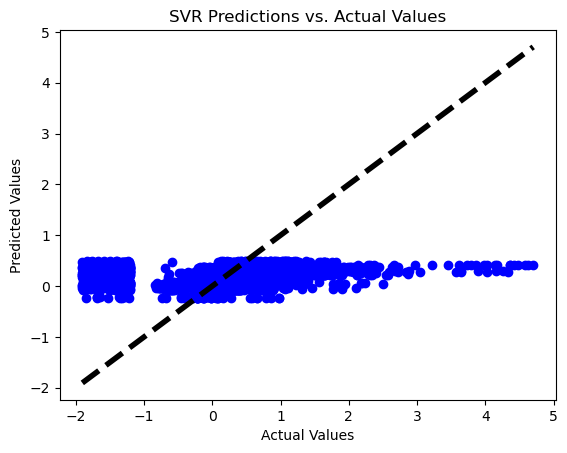

In [53]:
import matplotlib.pyplot as plt

# Plot the actual values and predicted values
plt.scatter(y_test, y_pred, color='blue')

# Add a diagonal line for comparison
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR Predictions vs. Actual Values')

# Show the plot
plt.show()

Interactive Dashboard
- Time Series Analysis Predictions

Dashboard 1.1
Data preprocessing

In [ ]:
# Filter the DataFrame based on the conditions
df_filtered = df[(df['indic'] == 'IS-HWI') & (df['normal'] == False) & (df['s_adj'] == 'NSA')].copy()

# Filter the DataFrame so only quarters from 2002 or later are included 
df_filtered = df_filtered[df_filtered['Quarter'] >= '2002-01-01']

In [ ]:
# Use interpolation to fill in missing values
df_filtered['Value'] = df_filtered['Value'].interpolate(limit_direction='both')

In [ ]:
# Add a new column to df_filtered called Value_Pred, with is the Value column + 10 - This will later be the predicted time series values.
df_filtered["Value_Pred"] = df_filtered["Value"] + 10

In [ ]:
# Print unique values of the 'Country_Codes' column
print(df_filtered['Country_Codes'].unique())

In [ ]:
# Print unique values of the 'geo\\TIME_PERIOD' column
print(df_filtered['geo\\TIME_PERIOD'].unique())

In [ ]:
# Where the 'Country_Codes' column is null, fill in the value of the 'geo\\TIME_PERIOD' column
df_filtered['Country_Codes'] = df_filtered['Country_Codes'].fillna(df_filtered['geo\\TIME_PERIOD'])

In [ ]:
# Define a function to parse the date string
def parse_quarter(date_string):
    year, quarter = date_string.split('-Q')
    month = (int(quarter) - 1) * 3 + 1
    return datetime(int(year), month, 1)

#Apply the parse_quarter function to the 'Quarter' column
df_filtered['Quarter'] = df_filtered['Quarter'].apply(parse_quarter)

In [ ]:
# Create a dictionary to map country codes to full names
country_names = {
 "NLD": "Netherlands",
 "LTU": "Lithuania",
 "BEL": "Belgium",
 "BGR": "Bulgaria",
 "CYP": "Cyprus",
 "EST": "Estonia",
 "ESP": "Spain",
 "FIN": "Finland",
 "HRV": "Croatia",
 "IRL": "Ireland",
 "ITA": "Italy",
 "LVA": "Latvia",
 "MNE": "Montenegro",
 "MLT": "Malta",
 "NOR": "Norway",
 "PRT": "Portugal",
 "SWE": "Sweden",
 "TUR": "Turkey",
 "MKD": "North Macedonia",
 "EA19" : "Euro Area (19 countries, 2015-2022)",
 "EA20" : "Euro Area (20 countries from 2023)",
}

# Create a new column in df_filtered with full country names
df_filtered["Country_Names"] = df_filtered["Country_Codes"].map(country_names)

In [ ]:
# Remove the EA19 and EA20 rows
df_filtered = df_filtered[df_filtered["geo\\TIME_PERIOD"].isin(["EA19", "EA20"]) == False]

In [ ]:
def add_max_column(df_filtered):
    max_values = df_filtered.groupby("Country_Codes")["Value"].transform("max")
    max_indices = df_filtered["Value"] == max_values
    df_filtered["Max"] = df_filtered.loc[max_indices, "Quarter"].dt.strftime("%Y-%m-%d") + " - " + df_filtered.loc[max_indices, "Value"].astype(str)
    return df_filtered

add_max_column(df_filtered)

def add_min_column(df_filtered):
    min_values = df_filtered.groupby("Country_Codes")["Value"].transform("min")
    min_indices = df_filtered["Value"] == min_values
    df_filtered["Min"] = df_filtered.loc[min_indices, "Quarter"].dt.strftime("%Y-%m-%d") + " - " + df_filtered.loc[min_indices, "Value"].astype(str)
    return df_filtered

add_min_column(df_filtered)


In [ ]:
# filter out all rows where the 'Max' column is null and assign the result to df_max
df_max = df_filtered[df_filtered['Max'].notnull()]

# filter out all rows where the 'Min' column is null and assign the result to df_min
df_min = df_filtered[df_filtered['Min'].notnull()]

# Merge df_filtered and df_max on the 'Country_Codes' column using a left join, keep only the Max column from df_max and rename it to 'Max'
df_filtered = df_filtered.merge(df_max[['Country_Codes', 'Max']], on='Country_Codes', how='left').rename(columns={'Max': 'Max'})

# Merge df_filtered and df_min on the 'Country_Codes' column using a left join, keep only the Min column from df_min and rename it to 'Min'
df_filtered = df_filtered.merge(df_min[['Country_Codes', 'Min']], on='Country_Codes', how='left').rename(columns={'Min': 'Min'})


In [ ]:
geolocator = Nominatim(user_agent="my-app")  # Initialize the geolocator

# country_codes is equal to the unique values of the 'geo\\TIME_PERIOD' column, filtering out EA19 and EA20
country_codes = df_filtered[df_filtered['geo\\TIME_PERIOD'] != 'EA19'][df_filtered['geo\\TIME_PERIOD'] != 'EA20']['geo\\TIME_PERIOD'].unique()

data = {"geo\\TIME_PERIOD": country_codes, "Latitude": [], "Longitude": []}

for country_code in country_codes:
    location = geolocator.geocode(country_code)
    if location is not None:
        data["Latitude"].append(location.latitude)
        data["Longitude"].append(location.longitude)
    else:
        data["Latitude"].append(None)
        data["Longitude"].append(None)

df_coords = pd.DataFrame(data)


In [ ]:
# Merge df_filtered and df_coords
df_filtered = df_filtered.merge(
    df_coords[
        [
            'geo\\TIME_PERIOD', 
            'Latitude', 
            'Longitude'
            ]
        ],
    left_on='geo\\TIME_PERIOD',
    right_on='geo\\TIME_PERIOD',
    how='left'
    ).rename(
        columns={
            'Latitude': 'Latitude', 
            'Longitude': 'Longitude'
            }
        )

In [ ]:
# Rename geo\\TIME_PERIOD to geo in df_filtered
df_filtered = df_filtered.rename(columns={'geo\\TIME_PERIOD': 'geo'})

# merge the comp_df and df_filtered on geo == geo and keeping all rows from comp_df
df_filtered = comp_df.merge(df_filtered, left_on='geo', right_on='geo', how='left')

In [ ]:
# Remove the EA19 and EA20 rows
df_filtered = df_filtered[df_filtered["geo"].isin(["EA19", "EA20"]) == False]

Dashboard 1.2
Create the Dashboard

In [ ]:
# Create initial figures
fig_line = px.line(df_filtered, x="Quarter_x", y=["Actual", "Predicted"], color="Country_Codes") 
fig_map = px.choropleth(df_filtered, locations="Country_Codes", color="Value")

# Add another line to fig_line based on Predicted column
fig_line.add_trace(go.Scatter(x=df_filtered["Quarter_x"], y=df_filtered["Predicted"], name="Predicted", mode="lines", line=dict(color="black", dash="dash")))

# Create app layout
app = JupyterDash(__name__) # Use JupyterDash instead of Dash
app.layout = html.Div([
 html.H2(
 "Quarterly Index (Non-Seasonally Adjusted)", 
 id="heading",
 style={"textAlign": "center"}
 ),
 dcc.RadioItems( 
 id="country-buttons", 
 options=[{"label": c, "value": c} for c in df_filtered["Country_Names"].unique()], # Use full country names as labels
 value=df_filtered["Country_Names"].iloc[0],
 style={"table-layout": "fixed", "width": "50%"}, # Style the container element 
 labelStyle={"display": "inline-block", "margin-right": "10px"} # Style each label element
 ),
 html.Div([ # Wrap line chart and map in a div with flex display
     html.Div([ # Wrap dropdown in a div with 50% width
         dcc.Graph(id="map-chart", figure=fig_map)
     ], style={"width": "50%"}),
     html.Div([ # Wrap map in a div with 50% width
         dcc.Graph(id="line-chart", figure=fig_line)
     ], style={"width": "100%"})
 ], style={"display": "flex", "flex-direction": "row"}),
])

# Define callback function
@app.callback(
 [Output("line-chart", "figure"), Output("map-chart", "figure"), Output("heading", "children")],
 [Input("country-buttons", "value")]
)


def update_charts(country_name):
 # Filter dataframe by selected country name
 df_country = df_filtered[df_filtered["Country_Names"] == country_name] 
 # Create new figures
 fig_line = px.line(df_country, x="Quarter_x", y="Actual", color="Country_Codes", hover_data={"Country_Names": True, "Quarter_x": True,"Actual": True, "Country_Codes": False}, labels={"Country_Names": "Country", "Quarter_x": "Quarter", "Actual": "Actual"}) 
 fig_map = px.choropleth(df_country, locations="Country_Codes", color="Value", hover_data={"Country_Names": True, "Max_y": True,"Min_y": True},labels={"Country_Names": "Country", "Max_y": "Max", "Min_y": "Min"}) 
 
 # Add another line to fig_line based on Value_Pred column
 fig_line.add_trace(go.Scatter(x=df_country["Quarter_x"], y=df_country["Predicted"], name="Predicted Value", mode="lines", line=dict(color="black", dash="dash")))
 
 # Update the hovermode and showlegend
 fig_map.update_layout(
    hovermode='closest'
 )
 
 #Customise Map Tooltip Options
 fig_map.update_traces(hovertemplate="<b>%{customdata[0]}</b><br>Max: %{customdata[1]}<br>Min: %{customdata[2]}<extra></extra>")
 
 # Use custom values for center based on latitude and longitude columns and higher value for projection.scale 
 fig_map.update_layout(geo=dict(center=dict(lat=df_country['Latitude'].iloc[0], lon=df_country['Longitude'].iloc[0]), projection_scale=5))
 
 
 # Return new figures
 return fig_line, fig_map, f"Quarterly Index (Non-Seasonally Adjusted) for {country_name}"


# Run app
app.run_server(mode="external") # Set mode to "inline" or "external"